In [1]:
import numpy as np
import pandas as pd
from numpy import nan

from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_validate,cross_val_predict,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,auc
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score,precision_recall_curve,accuracy_score,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold,RFECV
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2,mutual_info_classif
from sklearn.calibration import CalibratedClassifierCV,calibration_curve,CalibrationDisplay
from sklearn.metrics import multilabel_confusion_matrix
import xgboost as xgb
import os

from sklego.meta import Thresholder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import geopandas as gpd
import cartopy.crs as ccrs

In [7]:
#from min_distance import *

In [2]:
codeDir = os.path.dirname(os.path.abspath(os.getcwd()))
parentDir = os.path.dirname(codeDir)

### open training dataset

In [59]:
df = pd.read_feather(parentDir+'\\intermediate_datadev2')

# remove samples where max mrms intensity < min possible gage intensity
min_int = pd.read_feather(parentDir+'\\min_intensity_gage')
min_int['gage_id'] = min_int.index
min_int.min_intensity = min_int.min_intensity
df['min_int'] = [min_int.loc[min_int.gage_id==df.gage_id[i][0]].min_intensity.values[0] for i in df.index]

df = df.query('max_mrms > min_int')
# add gage source
source = pd.read_csv(parentDir+'\\gage_source.csv',index_col=0)
source['gage_id'] = source.index

df['source'] = [source.loc[source.gage_id==df.gage_id[i][0]].source.values[0] for i in df.index]

gage_source = df[['source','latitude','longitude']]

#df = df.reset_index(drop=True).drop(columns=['min_int','gage_id','max_accum_atgage'])
df = df.reset_index(drop=True).drop(columns=['min_int','max_accum_atgage','source'])
df.gage_id = [df.gage_id[i][0] for i in df.index]

# remove multiple gages in same MRMS grid
test = df.groupby(['latitude','longitude']).agg(list)
test['num_gage'] = [len(np.unique(test.gage_id[i])) for i in test.index]
test['i_gage'] = [np.unique(test.gage_id[i]) for i in test.index]

dup = test.loc[test.num_gage>1].reset_index().i_gage
gage_dup = [dup[i][1] for i in dup.index]
df = df.loc[~df.gage_id.isin(gage_dup)]

# shift lon to 255.5, was 255 when i developed dataset
df = df.loc[df.longitude<255.5]

df['label']=0
df.loc[(df.AR_peak<=1/.3)&(df.AR_peak>=.3)&(df.AR_accum<=1/.25)&(df.AR_accum>=.25),['label']]=1

df = df.loc[(df.AR_peak!=np.inf)&(df.AR_accum!=np.inf)]
df = df.drop(columns=['AR_peak','AR_accum'])
#df = df.drop(columns=['std_int_point','std_accum_point','mean_accum_point','accum_mean_storm','accum_std_storm'])

df = df.dropna()

data = df.drop(columns=['label','gage_id'])
labels = df.label.values
scaler = StandardScaler()
data=scaler.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)

### look at samples on edge of threshold

In [ ]:
df1 = pd.read_csv(parentDir+'\\window_values.csv',index_col=0)

df1['mrms']=[eval(df1.mrms[i]) for i in df1.index]
df1['gage']=[eval(df1.gage[i]) for i in df1.index]


df1 = df1.query('max_mrms > min_int')

df1 = remove_closest(df1,distance_lessthan)

df1 = df1.loc[df1.longitude<255.5]

df1 = df1.dropna()

test=df1.loc[(df1.label==1)&(df1.max_mrms>20)&(df1.AR_peak<=1/.3)&(df1.AR_peak>=1/.35)]

for i in test.index:
    plt.plot(test.mrms[i],label='mrms')
    plt.plot(test.gage[i],label='gage')
    plt.legend()
    plt.show()

In [4]:
df1 = pd.read_csv(parentDir+'\\int_data2.csv',index_col=0)
df1['AR_peak'] = df1.max_mrms/df1.max_gage
df1['AR_accum'] = df1.total_accum_atgage/df1.total_gage_accum


df1['label']=0
df1.loc[(df1.AR_peak<=1/.3)&(df1.AR_peak>=.3)&(df1.AR_accum<=1/.25)&(df1.AR_accum>=.25),['label']]=1
df1 = df1.loc[(df1.AR_peak!=np.inf)&(df1.AR_accum!=np.inf)]

df1 = df1.dropna()

# drop gages within 10km
locations = df1.groupby(['latitude','longitude']).count().reset_index().iloc[:,0:2]
index = locations.round(decimals=1).drop_duplicates().index

df1['coord'] = list(zip(df1.latitude,df1.longitude))
locations = locations.iloc[index].reset_index()
locations.to_feather(parentDir+'\\training_lat_lon')
locations = list(zip(locations.latitude,locations.longitude))

df1 = df1.loc[df1.coord.isin(locations)].drop(columns='coord')

df1['mrms']=[eval(df1.mrms[i]) for i in df1.index]
df1['gage']=[eval(df1.gage[i]) for i in df1.index]
df1['mrms_accum_atgage']=[eval(df1.mrms_accum_atgage[i]) for i in df1.index]
df1['gage_accum']=[eval(df1.gage_accum[i]) for i in df1.index]

In [5]:
#good at margin
test1=df1.loc[(df1.label==1)&(df1.max_mrms>20)&(df1.AR_peak<=1/.3)&(df1.AR_peak>=3.31)]
test2=df1.loc[(df1.label==1)&(df1.max_mrms>20)&(df1.AR_peak>=.3)&(df1.AR_peak<=.37)]

#bad at margin
bad=df1.loc[(df1.label==0)&(df1.max_mrms>20)&(df1.AR_peak<=2)&(df1.AR_peak>=.5)]
index=bad.index

test3 = bad.loc[bad.index==index[0]]
test4 = bad.loc[bad.index==index[1]]


#test4=df1.loc[(df1.label==0)&(df1.max_mrms>20)&(df1.AR_peak>=.25)&(df1.AR_peak<.3)]


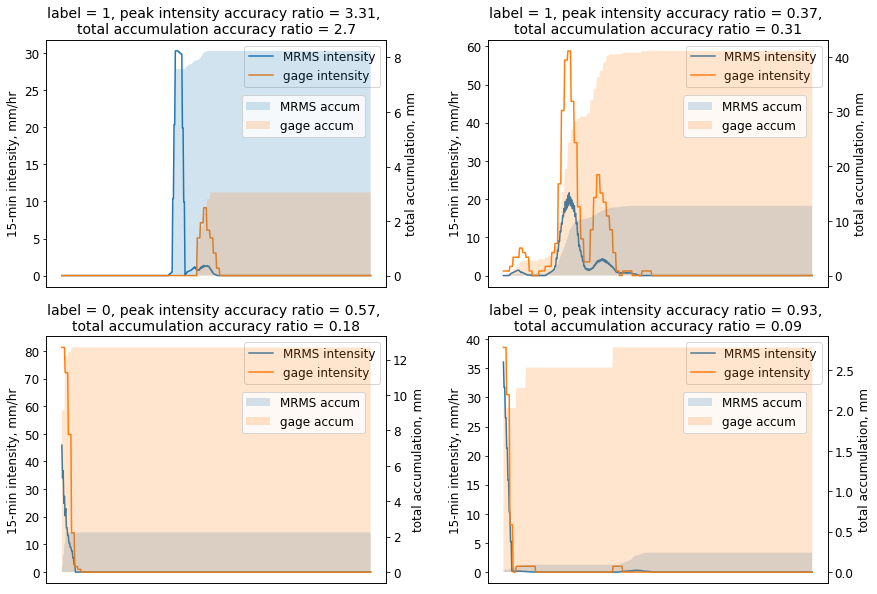

In [265]:
# example of good and bad on margin
fig, axs = plt.subplots(2,2, figsize=(14,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.3)
axs = axs.ravel()

for i,test in enumerate([test1,test2,test3,test4]):
    index=test.index[0]
    
    plt.xticks([])     
    axs[i].tick_params(labelsize = 12)   

    ax2 = axs[i].twinx()
    ax2.tick_params(labelsize = 12)
    
    axs[i].plot(test.mrms[index],label='MRMS intensity')
    axs[i].plot(test.gage[index],label='gage intensity')
    
    test_accum = pd.DataFrame(test['mrms_accum_atgage'][index]).fillna(0).cumsum()

    ax2.fill_between(range(len(test_accum)),test_accum.values[:,0],alpha=.2,label='MRMS accum')
    ax2.fill_between(range(480),np.cumsum(test['gage_accum'][index]),alpha=.2,label='gage accum')    

    axs[i].set_ylabel('15-min intensity, mm/hr',fontsize=12)
    ax2.set_ylabel('total accumulation, mm',fontsize=12)

    label = test.label.values[0]
    AR_peak = round(test.AR_peak.values[0],2)
    AR_accum = round(test.AR_accum.values[0],2)

    axs[i].set_title('label = '+str(label)+', peak intensity accuracy ratio = '+str(AR_peak)+
                     ', \ntotal accumulation accuracy ratio = '+str(AR_accum),fontsize=14)

    axs[i].legend(fontsize=12,loc='upper right')
    ax2.legend(fontsize=12,loc='upper right', bbox_to_anchor=(.955, 0.80))

    #plt.title(name,fontsize=20)
    #plt.show()
    
fig.savefig("margin_examples.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [219]:
# plot standardized pdf for good and bad AR_peak and AR_accum


In [25]:
good = df.loc[df.label==1]
bad = df.loc[df.label==0]

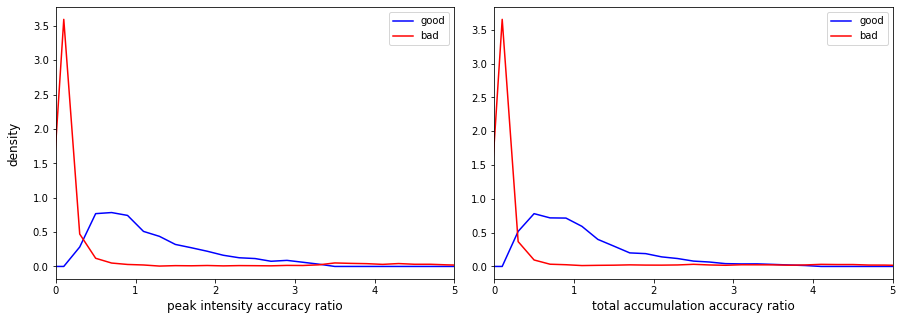

In [46]:
xinc = 0.2
xbins = np.arange(-1, 6, xinc)

fig, axs = plt.subplots(1,2, figsize=(15,5), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()
fig.text(0.08, 0.5, 'density', va='center', rotation='vertical',fontsize=12)

x = good.AR_peak
y = bad.AR_peak
hx = np.histogram(x,xbins)
hy = np.histogram(y,xbins)

xvals = hx[1][:-1]
fvalsx = hx[0].astype(float)/(np.size(x)*xinc)
fvalsy = hy[0].astype(float)/(np.size(y)*xinc)

axs[0].plot(xvals+xinc/2,fvalsx,'b', label = 'good',linewidth=1.5)
axs[0].plot(xvals+xinc/2,fvalsy,'r', label = 'bad',linewidth=1.5)
axs[0].set_xlim(0,5)
axs[0].set_xlabel('peak intensity accuracy ratio',fontsize=12)
axs[0].legend()

x = good.AR_accum
y = bad.AR_accum
hx = np.histogram(x,xbins)
hy = np.histogram(y,xbins)

xvals = hx[1][:-1]
fvalsx = hx[0].astype(float)/(np.size(x)*xinc)
fvalsy = hy[0].astype(float)/(np.size(y)*xinc)


axs[1].plot(xvals+xinc/2,fvalsx,'b', label = 'good',linewidth=1.5)
axs[1].plot(xvals+xinc/2,fvalsy,'r', label = 'bad',linewidth=1.5)
axs[1].set_xlim(0,5)
axs[1].set_xlabel('total accumulation accuracy ratio',fontsize=12)
axs[1].legend()


fig.savefig("hist_labels.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

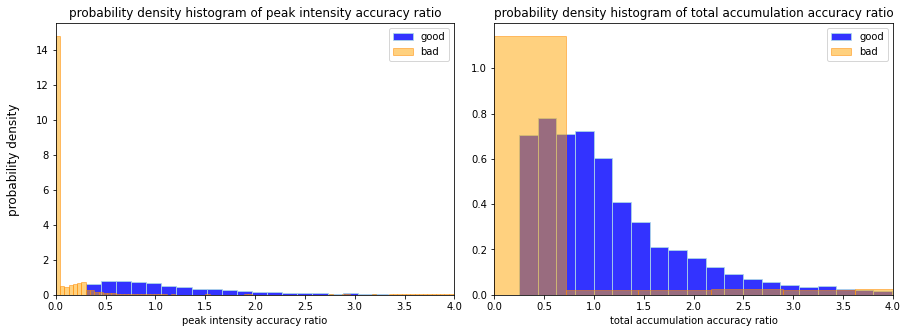

In [10]:
fig, axs = plt.subplots(1,2, figsize=(15,5), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()
fig.text(0.08, 0.5, 'probability density', va='center', rotation='vertical',fontsize=12)

axs[0].hist(good.AR_peak,bins=20,density=True,label='good', lw=1,ec="lightblue", fc="blue", alpha=0.8)
axs[0].hist(bad.AR_peak,bins=20,density=True,label='bad', lw=1,ec="darkorange", fc="orange", alpha=0.5)
axs[0].set_xlim(0,4)
axs[0].set_title('probability density histogram of peak intensity accuracy ratio')
axs[0].set_xlabel('peak intensity accuracy ratio')
axs[0].legend()

axs[1].hist(good.AR_accum,bins=20,density=True,label='good', lw=1,ec="lightblue", fc="blue", alpha=0.8)
axs[1].hist(bad.AR_accum,bins=20,density=True,label='bad', lw=1,ec="darkorange", fc="orange", alpha=0.5)
axs[1].set_xlim(0,4)
axs[1].set_title('probability density histogram of total accumulation accuracy ratio')
axs[1].set_xlabel('total accumulation accuracy ratio')
axs[1].legend()
fig.savefig("hist_labels.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

## plot distribution of gage data

In [165]:
import rioxarray as rxr
import matplotlib.gridspec as gridspec
from metpy.plots import USCOUNTIES
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [166]:
datafile1 = parentDir+"\\CO_SRTM1arcsec__merge.tif"
codtm = rxr.open_rasterio(datafile1)
newelev = codtm.drop_vars('band')

noband = newelev.sel(band=0)

noband = noband[{'x': slice(None, None, 10), 'y': slice(None, None, 10)}][{}]
lon, lat = np.meshgrid(noband.x,noband.y)

In [167]:
test = df.groupby(['latitude','longitude']).count().gage_id.reset_index()

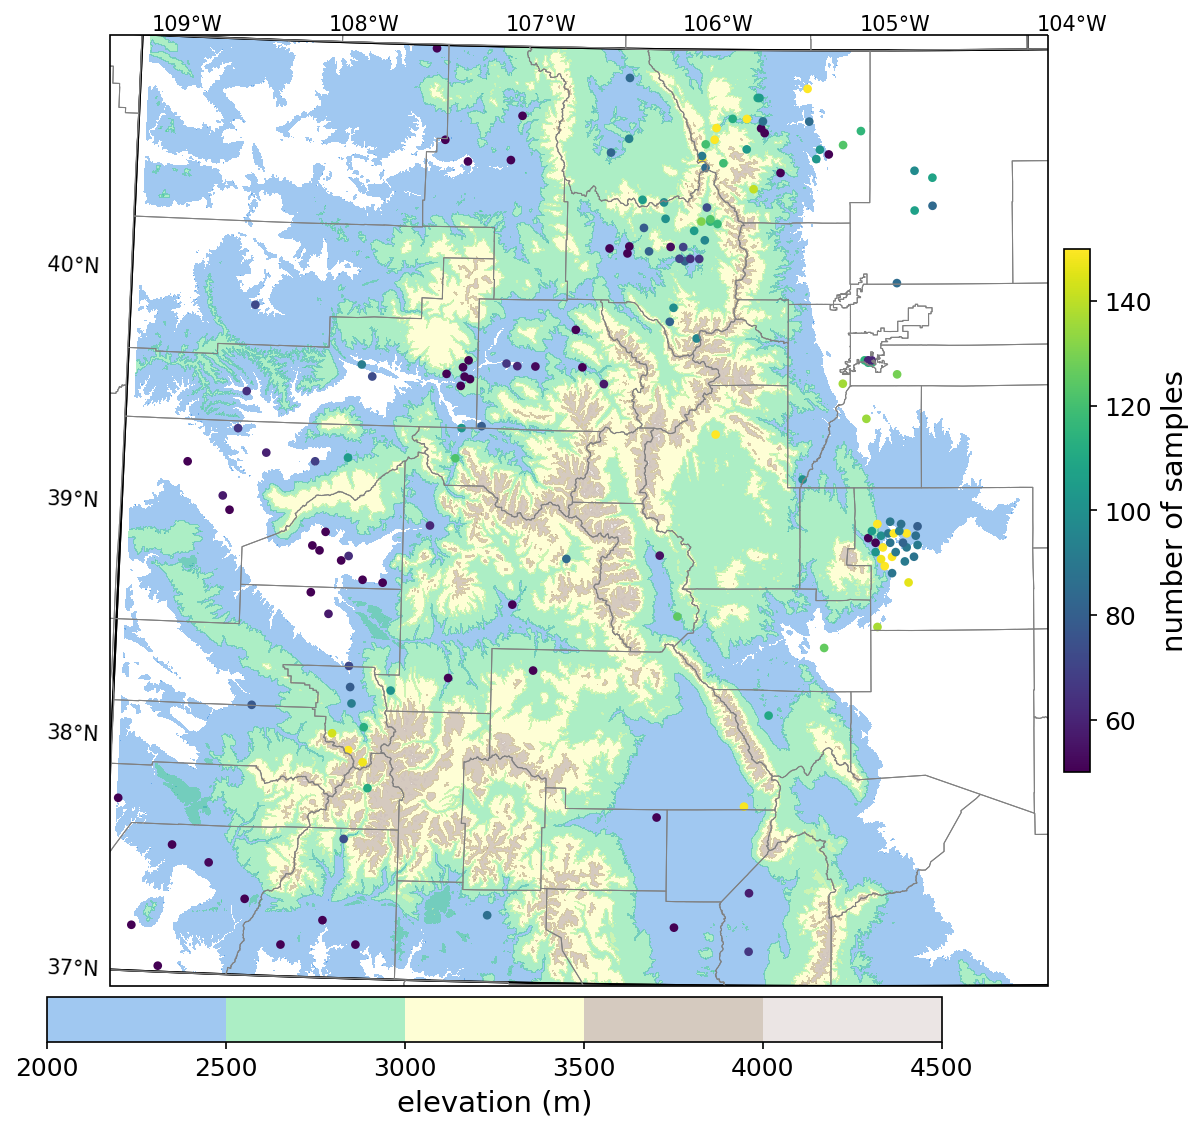

In [171]:
fig = plt.figure(1, figsize=(14,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-105)
ax = plt.subplot(1,1,1, projection=plotcrs)


elev=ax.contourf(lon,lat, noband, levels=list(range(2000, 5000, 500)), origin='upper',cmap='terrain', 
            alpha=0.4,transform=ccrs.PlateCarree())
cb =fig.colorbar(elev,orientation="horizontal", shrink=.55,pad=0.01)
cb.ax.tick_params(labelsize=12)
cb.set_label("elevation (m)", fontsize=14)

ax.add_feature(cfeature.STATES, linewidth=1)

ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.5, edgecolor='gray')

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  alpha=0, 
                  draw_labels=True, 
                  dms=True, 
                  x_inline=False, 
                  y_inline=False)
gl.xlabel_style = {'rotation':0}
# add these before plotting
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

'''plt.scatter(df1.longitude,df1.latitude,transform=ccrs.PlateCarree(),label='USGS',marker='x',color='red')
plt.scatter(df2.longitude,df2.latitude,transform=ccrs.PlateCarree(),label='CSU',marker='x',color='#FF00FF')
plt.scatter(df3.longitude,df3.latitude,transform=ccrs.PlateCarree(),label='CoAgMET',marker='x',color='darkblue')
#plt.scatter(df4.longitude,df4.latitude,transform=ccrs.PlateCarree(),label='ARS',marker='x',color='purple')'''

g = ax.scatter(test.longitude,test.latitude,transform=ccrs.PlateCarree(),
               c = test.gage_id,vmin=50,vmax=150,s=10)
cb2 =fig.colorbar(g,orientation="vertical", shrink=.55,pad=0.01)
cb2.ax.tick_params(labelsize=12)
cb2.set_label("number of samples", fontsize=14)


#plt.legend()

fig.savefig("gage_map.pdf",
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')


## how well does RQI show subhourly performance?

In [ ]:
# how well does RQI show subhourly performance?
len(df.loc[(df.RQI>=.9)&(df.label==1)])/len(df.loc[(df.RQI>=.9)])

from scipy import stats
test = df.loc[df.AR_peak>1]
res = stats.linregress(test.RQI, test.AR_peak)
print(f"R-squared: {res.rvalue**2:.6f}")

## look at predict dataset

In [60]:
predict = pd.read_feather(parentDir+'\\predict')

predict = predict.rename(columns={'correction':'mult_correct'})
predict=predict.reindex(columns=df.columns.drop(['label','gage_id']))

predict=predict.dropna()
#predict=predict.loc[predict.max_mrms>1]

predict_s =scaler.fit_transform(predict)

In [61]:
clf = GradientBoostingClassifier(n_estimators=200, min_samples_split=3, min_samples_leaf=2,
                                 max_depth=6, learning_rate=0.05,random_state=0)
pipe = Pipeline([
("model", Thresholder(clf, threshold=0.7))
])
pipe.fit(X_train,y_train)
y_pred = pipe.predict_proba(predict_s)
predict['neg_prob'] = y_pred[:, 0]
predict['pos_prob'] = y_pred[:, 1]
predict['label'] = pipe.predict(predict_s)

In [119]:
# mean rqi
predict_mean_rqi = predict.loc[(predict.total_accum_atgage>1)].groupby(['latitude','longitude']).median().RQI
predict_mean_rqi = predict_mean_rqi.to_xarray()
# mean ms correct
predict_mean_ms = predict.loc[(predict.total_accum_atgage>1)].groupby(['latitude','longitude']).median().mult_correct
predict_mean_ms = predict_mean_ms.to_xarray()
# mean total accum
predict_mean_accum = predict.loc[(predict.total_accum_atgage>1)].groupby(['latitude','longitude']).quantile(.9).total_accum_atgage
predict_mean_accum = predict_mean_accum.to_xarray()
# mean duration
predict_mean_d = predict.loc[(predict.total_accum_atgage>1)].groupby(['latitude','longitude']).median().duration
predict_mean_d = predict_mean_d.to_xarray()

In [21]:
# mean probability of pos label
predict_med_pos = predict.loc[predict.total_accum_atgage>1].groupby(['latitude','longitude']).median().pos_prob
predict_med_pos= predict_med_pos.to_xarray()

In [62]:
# how many samples per grid
count = predict.loc[predict.total_accum_atgage>1].groupby(['latitude','longitude']).count().max_mrms
#count = predict.groupby(['latitude','longitude']).count().max_mrms
# frequency of positive label
count_pos = predict.loc[(predict.label==1)&(predict.total_accum_atgage>1)].groupby(['latitude','longitude']).count().max_mrms
#count_pos = predict.loc[(predict.label==1)].groupby(['latitude','longitude']).count().max_mrms
freq_pos = (count_pos/count).to_xarray()
count = count.to_xarray()

In [7]:
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

In [152]:
test = freq_pos.fillna(0)
title = "frequency of positive class"

In [85]:
np.arange((1/11*100),100+(2/11*100),(2/11*100))

array([  9.09090909,  27.27272727,  45.45454545,  63.63636364,
        81.81818182, 100.        ])

In [153]:
cmap_data = [(255,255,255),

(255,255,204),
(161,218,180),
#(65,182,196),
(44,127,184),
(37,52,148)]

cmap_data_N=[]
for i in cmap_data:
    cmap_data_N.append([c/255 for c in i])

cmap2 = LinearSegmentedColormap.from_list('custom',cmap_data_N)

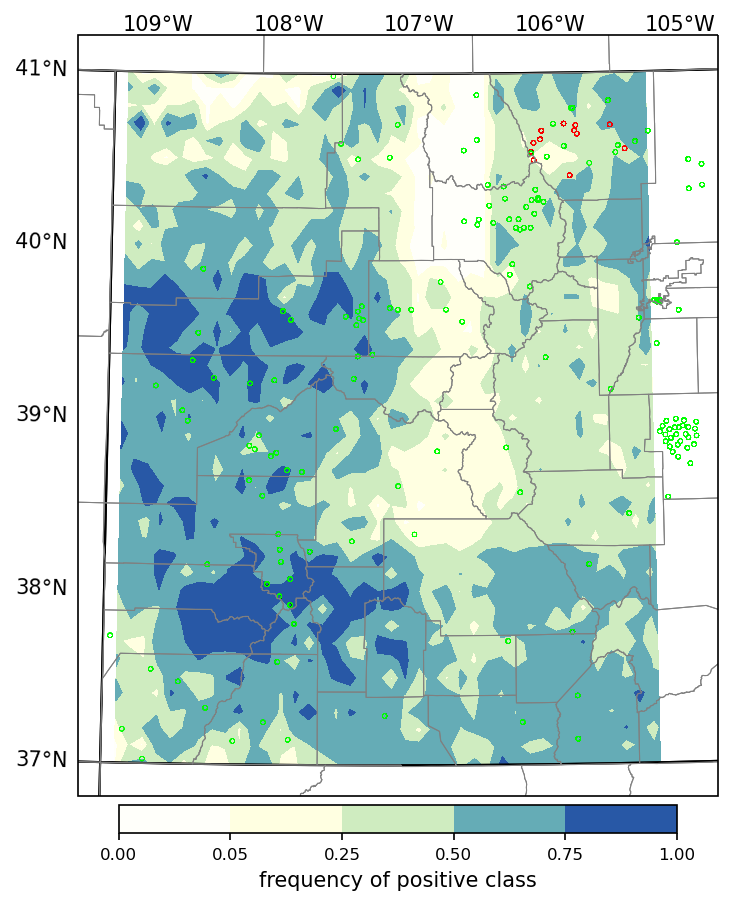

In [163]:
fig = plt.figure(1, figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-107)

ax = plt.subplot(1,1,1, projection=plotcrs)

# Set plot bounds -- or just comment this out if wanting to plot the full domain
ax.set_extent((-109.2, -104.6, 36.8, 41.2))

plt.rcParams['figure.dpi'] = 150

elev=ax.contourf(count.longitude, count.latitude,test, origin='upper',cmap=cmap2, 
            transform=ccrs.PlateCarree(),levels=[0,0.05,.25,.5,.75,1])#,levels=[count.min(),20,50,100,200,count.max()])
cb =fig.colorbar(elev,orientation="horizontal", shrink=.4,pad=0.01)
cb.ax.tick_params(labelsize=8)
cb.set_label(title, fontsize=10)
#plt.title(title,size=20)
''''''
gage_source = gage_source.loc[gage_source.longitude<255.5]
ax.scatter(gage_source.loc[(gage_source.source=='csu')].longitude,gage_source.loc[(gage_source.source=='csu')].latitude,
           transform=ccrs.PlateCarree(),s = 5, color='r',facecolors='none',linewidth=.2)
ax.scatter(gage_source.loc[(gage_source.source!='csu')].longitude,gage_source.loc[(gage_source.source!='csu')].latitude,
           transform=ccrs.PlateCarree(),s = 5, color='lime',facecolors='none',linewidth=.2)

#elev2=ax.contourf(lon,lat,noband, levels=list(range(3000, 5000, 1000)), colors='fuchsia',origin='upper', 
                 #alpha=0.4,transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES, linewidth=1)

ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.5, edgecolor='gray')

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  alpha=0, 
                  draw_labels=True, 
                  dms=True, 
                  x_inline=False, 
                  y_inline=False)
gl.xlabel_style = {'rotation':0}
# add these before plotting
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
fig.savefig("freq.pdf",
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [143]:
test = predict.loc[(predict.total_accum_atgage>10)]

In [204]:
predict['longitude'] = predict.longitude+360

In [195]:
test = predict.loc[(predict.total_accum_atgage>10)].groupby(['point_elev','longitude']).mean().pos_prob.to_xarray()

In [244]:
test = predict

In [245]:
# bin latitude and longitude, include entire study area
bins = np.linspace(test.latitude.min(),test.latitude.max(),num=30)
labels = bins[0:-1]

test['latitude'] = pd.cut(x = df['latitude'], bins = bins, labels = labels, include_lowest = True)

bins = np.linspace(test.point_elev.min(),test.point_elev.max(),num=10)
labels = bins[0:-1]

test['point_elev'] = pd.cut(x = df['point_elev'], bins = bins, labels = labels, include_lowest = True)

In [246]:
test = test.groupby(['point_elev','longitude']).mean().pos_prob.to_xarray()

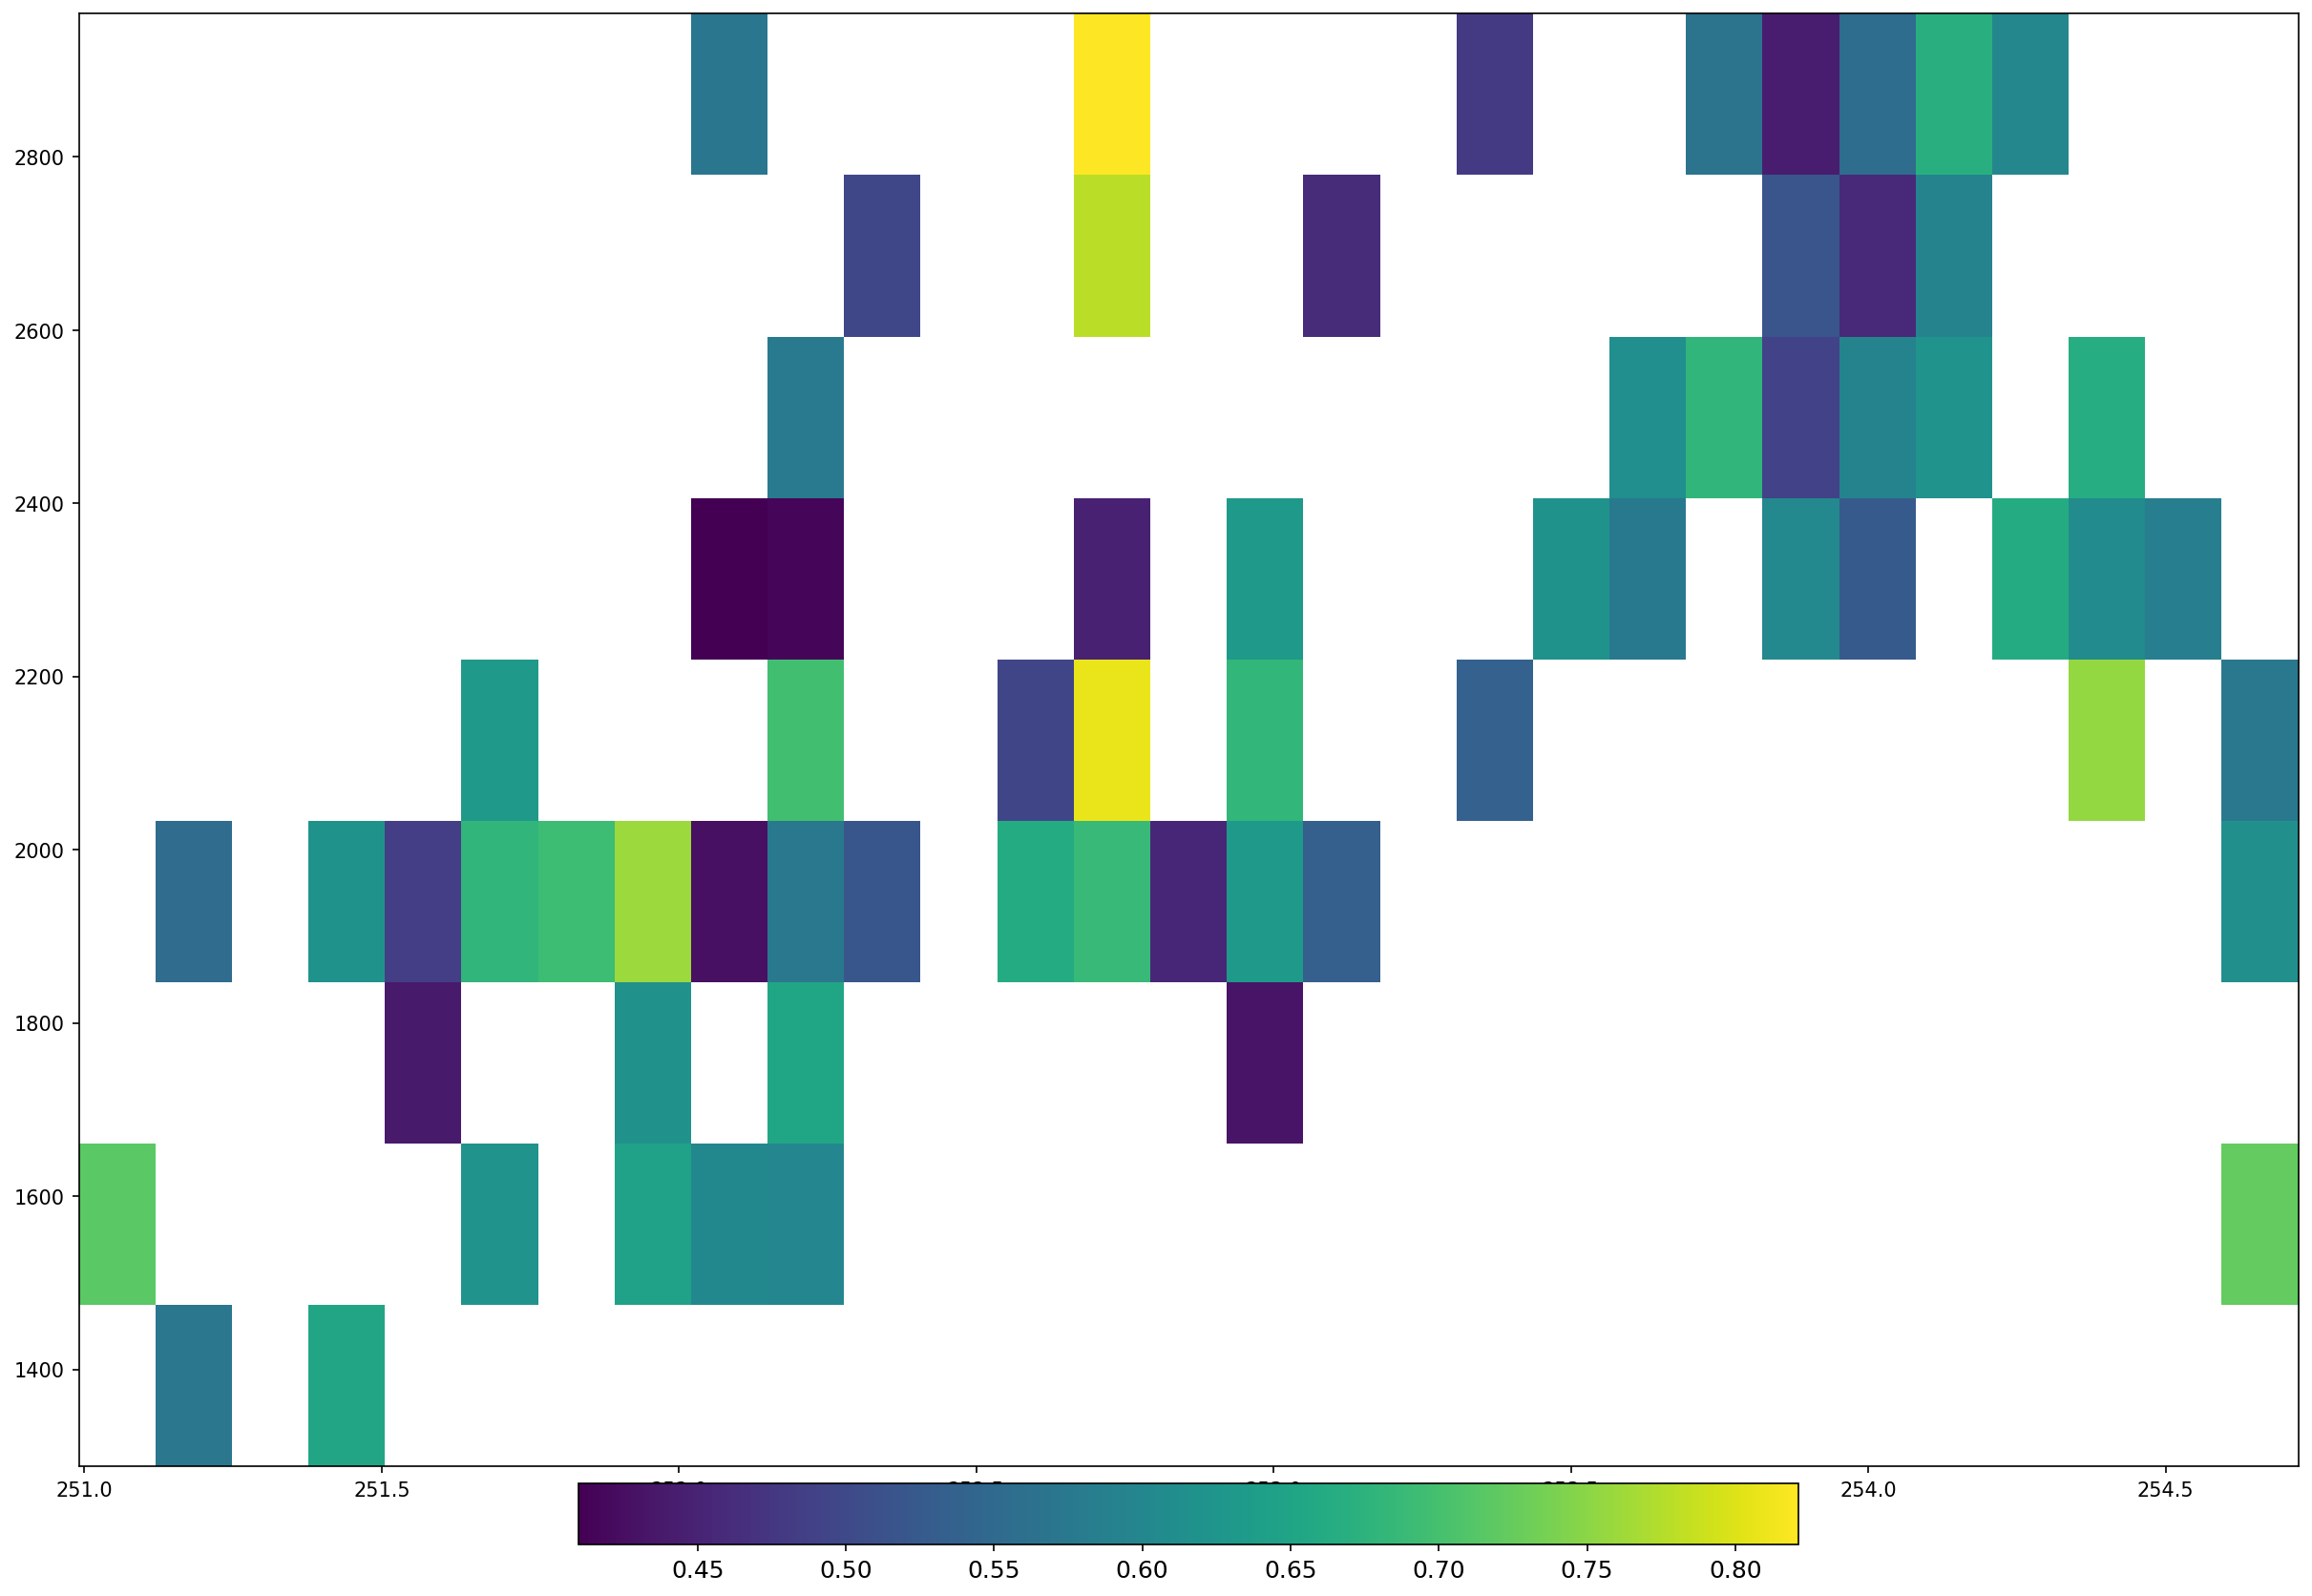

In [247]:
fig = plt.figure(1, figsize=(20,16))

x=plt.pcolormesh(test.longitude,test.point_elev,test)
cb =fig.colorbar(x,orientation="horizontal", shrink=.55,pad=0.01)
cb.ax.tick_params(labelsize=12)

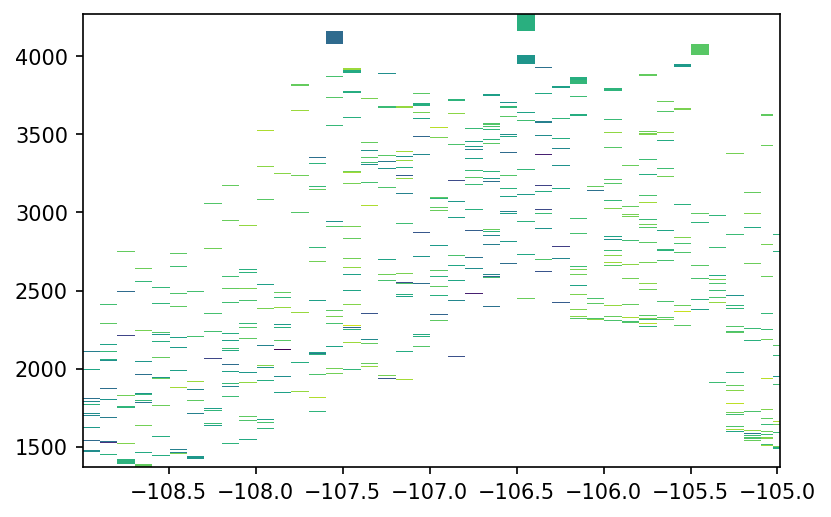

In [196]:
plt.pcolormesh(test.longitude,test.point_elev,test)

In [ ]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(data)

colors = ["navy", "darkorange"]
markers=['x','+']
fig = plt.figure(1, figsize=(10,8))

for marker,color, i in zip(markers,colors, [0,1]):
    plt.scatter(
        X_r[labels == i, 0], X_r[labels == i, 1],color=color, marker=marker,alpha=0.8, lw=2, label=i
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)

In [ ]:
data=scaler.fit_transform(df.drop(columns='label'))
t_sne = TSNE(n_components=2,random_state=1)
S_t_sne = t_sne.fit_transform(data)

In [ ]:
colors = ["navy", "darkorange","darkgreen" ]
markers=['x','+','*']

fig, axs = plt.subplots(ncols=2, nrows=2, gridspec_kw={'width_ratios': [2, 1]},figsize=(10,6))
gs = axs[0,1].get_gridspec()
# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[0:, 0])


for marker,color, i in zip(markers,colors, [0,1]):
    axbig.scatter(
        S_t_sne[labels == i, 0], S_t_sne[labels == i, 1],color=color, marker=marker,alpha=0.5, lw=.8, label=i
    )
plt.legend(['label = 0','label = 1'],loc="best", shadow=False,scatterpoints=1,markerscale=1.5)
#plt.title("t-sne")

for marker,color, i in zip(markers,colors, [0]):
    axs[0,1].scatter(
        S_t_sne[labels == i, 0], S_t_sne[labels == i, 1],color="navy", marker='x',alpha=0.5, lw=.5, label=i
    )
for marker,color, i in zip(markers,colors, [1]):
    axs[1,1].scatter(
        S_t_sne[labels == i, 0], S_t_sne[labels == i, 1],color="darkorange", marker='+',alpha=0.5, lw=.5, label=i
    )
axbig.legend(['label = 0','label = 1'],loc="best", shadow=False,scatterpoints=1,markerscale=1.5)
axs[0,1].set_title('label = 0')
axs[1,1].set_title('label = 1')

axbig.set_xticks([])
axbig.set_yticks([])
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
fig.tight_layout()
fig.savefig("tsne.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')